In [1]:
import datetime
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from emoji import get_emoji_regexp
from nltk.sentiment import SentimentIntensityAnalyzer
from random import shuffle
from sklearn import preprocessing
from time import strptime
from wordcloud import WordCloud, STOPWORDS

# Import data
reddit = pd.read_csv('./Datasets/reddit_wsb.csv')

# Data cleaning functions
emoji_pattern = get_emoji_regexp()

def remove_emojis(text):
    return re.sub(emoji_pattern, '', text)

def remove_punctuations(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def remove_tags(text):
    return re.sub('@[\w]*', '', text)

def remove_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

# Extract out relevant data - the thread title and timestamp only
reddit = reddit[['title', 'timestamp']]

# Data Cleaning
reddit['title'] = reddit['title'].str.lower()
reddit['title'] = reddit['title'].apply(lambda x: remove_emojis(x))
reddit['title'] = reddit['title'].apply(lambda x: remove_URLs(x))
reddit['title'] = reddit['title'].apply(lambda x: remove_tags(x))
reddit['title'] = reddit['title'].apply(lambda x: remove_punctuations(x))
reddit['title'] = reddit['title'].apply(lambda x: x.strip()) # Removes leading and trailing whitespaces

# Change Timestamp to date format
reddit['timestamp'] = pd.to_datetime(reddit['timestamp']).dt.date
reddit.rename(columns = {'timestamp': 'date'}, inplace = True)

# Removes any rows with dates outside of 2021
reddit = reddit[reddit['date'] >= datetime.date(2021, 1, 1)]

# Removes rows with empty titles
reddit = reddit[reddit['title'] != '']

# Resets row index
reddit = reddit.reset_index(drop = True)

In [2]:
reddit

,title,date
0,its not about the money its about sending a me...,2021-01-28
1,math professor scott steiner says the numbers ...,2021-01-28
2,exit the system,2021-01-28
3,new sec filing for gme can someone less retard...,2021-01-28
4,not to distract from gme just thought our amc ...,2021-01-28
...,...,...
53016,what i learned investigating sava fud spreaders,2021-08-02
53017,daily popular tickers thread for august 02 202...,2021-08-02
53018,hitler reacts to the market being irrational,2021-08-02
53019,daily discussion thread for august 02 2021,2021-08-02


In [3]:
# Filter out relevant words => did not filter out specific words since all from a specialised thread

# Conducting sentiment analysis using VADER model 
sia = SentimentIntensityAnalyzer()

reddit['negative'] = 0
reddit['positive'] = 0
reddit['neutral'] = 0
reddit['compound'] = 0
reddit['sentiment'] = 0

for i in range(len(reddit['title'])):
    sentence = reddit['title'][i]
    scores = sia.polarity_scores(sentence)
    
    reddit.loc[i, 'negative'] = scores.get('neg')
    reddit.loc[i, 'positive'] = scores.get('pos')
    reddit.loc[i, 'neutral'] = scores.get('neu')
    reddit.loc[i, 'compound'] = scores.get('compound')

    if scores.get('compound') > 0: 
        reddit.loc[i, 'sentiment'] = 1
    elif scores.get('compound') == 0: 
        reddit.loc[i, 'sentiment'] = 0
    else: 
        reddit.loc[i, 'sentiment'] = -1


In [4]:
#group the threads within dates to get the numbers out

column_names = ['date', 'number', 'avg']
redditnumber = pd.DataFrame(columns = column_names)
                            
sumcpd = 0 
length = 1
counter = 0 
                            
for i in range(len(reddit) - 1):
    if ((reddit.loc[i, 'date']) == (reddit.loc[i + 1, 'date'])):
        sumcpd += reddit.loc[i, 'compound']
        length += 1
    
    else:         
        counter += 1
        
        # Extract the dates to aggregate 
        redditnumber.loc[counter, 'date'] = reddit.loc[i, 'date']
        redditnumber.loc[counter, 'avg'] = float(sumcpd/length)
       
        # Extract the sentiment score 
        sumcpd += reddit.loc[i, 'compound']
        redditnumber.loc[counter, 'avg'] = float(sumcpd/length)
        redditnumber.loc[counter, 'number'] = length
        
        sumcpd = 0 
        length = 1                        

redditnumber[500:550]

,date,number,avg
501,2021-05-19,49,0.14771
502,2021-05-18,71,0.092577
503,2021-05-17,28,-0.000882
504,2021-05-16,21,0.13811
505,2021-05-15,73,0.112518
506,2021-05-14,110,0.102239
507,2021-05-13,100,0.088414
508,2021-05-12,65,0.094591
509,2021-05-30,2,-0.3825
510,2021-05-29,4,0.159025


In [5]:
reddit_wsb_daily = redditnumber.to_csv("Datasets/reddit_wsb_daily.csv")

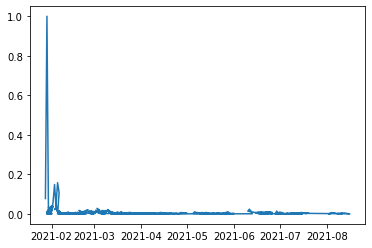

In [6]:
def normalize_data(df):
    minimum = min(df)
    maximum = max(df)
    x = df 
    y = (x - minimum) / (maximum  - minimum)
    return y


x = redditnumber['date']

avg = normalize_data(redditnumber['avg'])
number = normalize_data(redditnumber['number'])

plt.plot(x, number)

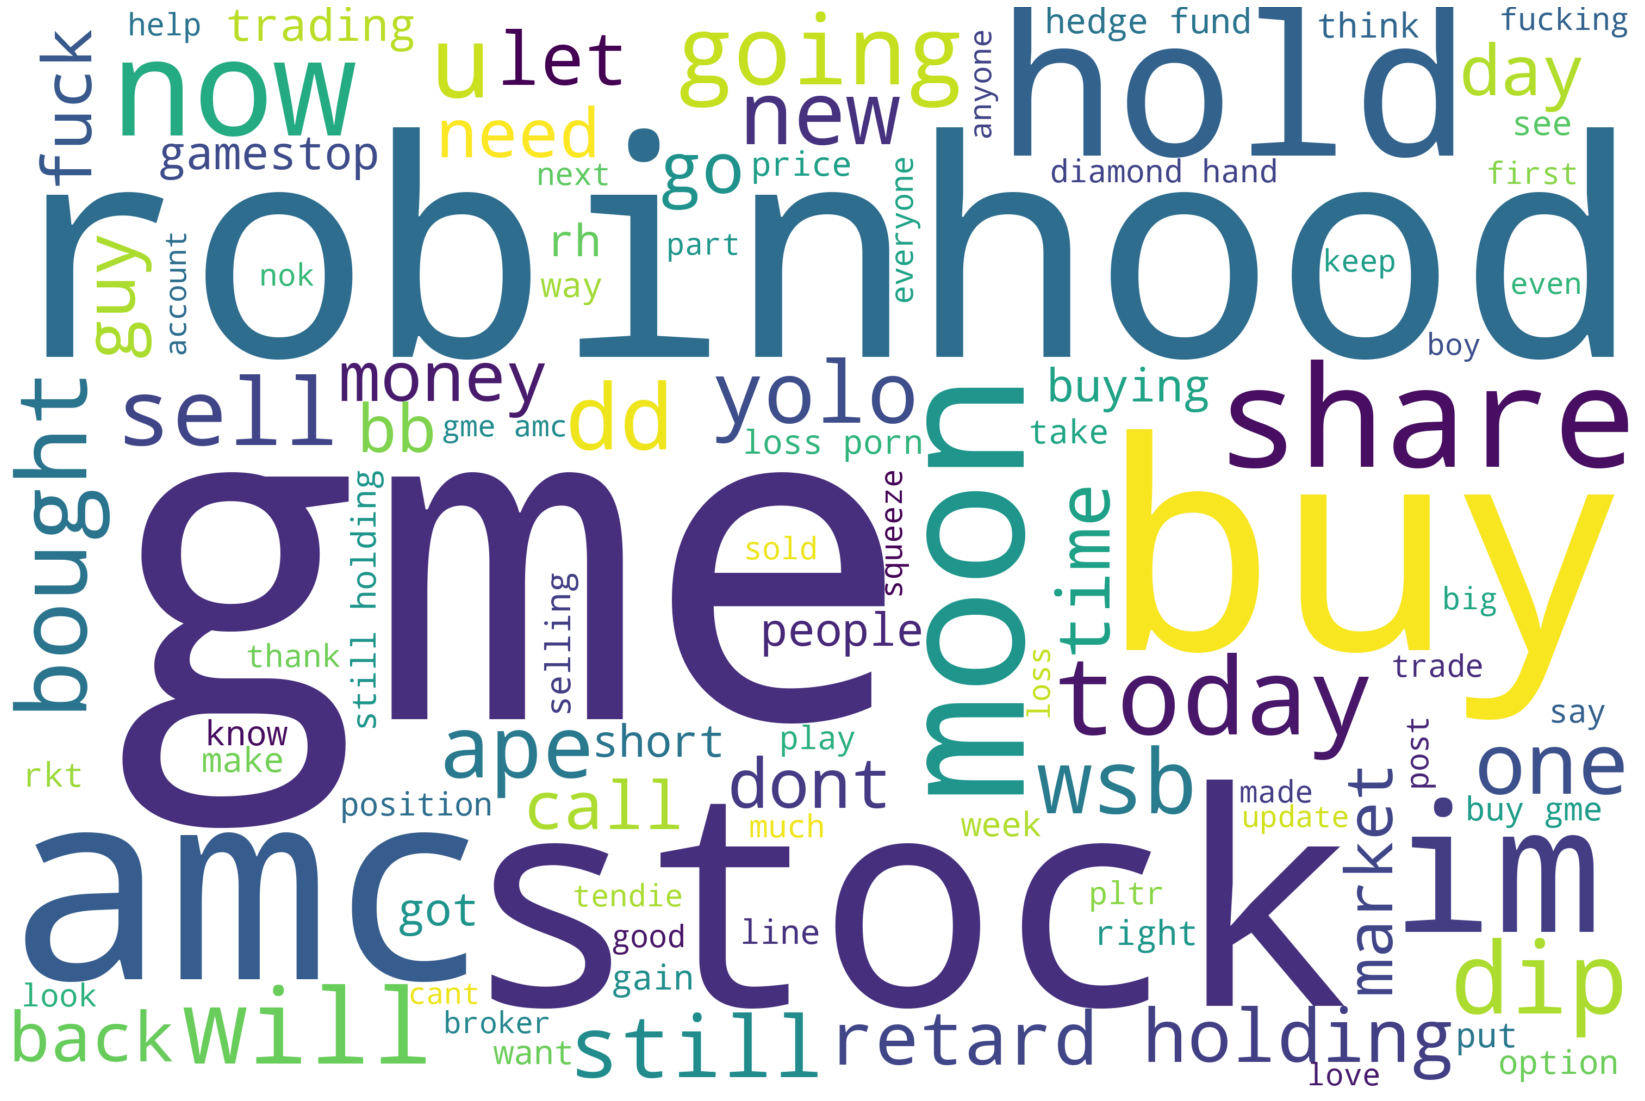

In [7]:
text = ' '.join(title for title in reddit['title'])

# Generates a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                      max_words = 100, stopwords = STOPWORDS).generate(text)

# Displays the wordcloud image
plt.figure(figsize = (30,20))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()